In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import tensorflow as tf

2023-04-18 14:10:33.592577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"

In [48]:
def process_ts_lsq_results(result_dir: str,
                           num_runs: int,
                           failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [49]:
def process_ts_gsbp_results(result_dir: str,
                            num_runs: int,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [50]:
def process_original_albo_lsq_results(result_dir: str,
                                      num_runs: int,
                                      failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [51]:
def process_original_albo_gsbp_results(result_dir: str,
                                       num_runs: int,
                                       failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [57]:
def process_kkt_lsq_results(result_dir: str,
                            num_runs: str,
                            failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))

    # Not all runs last 50 iterations due to early stopping criteria
    for i in range(len(all_results)):
        run_results = all_results[i].tolist()
        if len(run_results) < 50:
            deficit = 50 - len(run_results)
            additional_array = deficit * [run_results[-1]]
            run_results += additional_array
            all_results[i] = run_results

    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [73]:
def process_kkt_gsbp_results(result_dir: str,
                            num_runs: str,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))

    # Not all runs last 160 iterations due to early stopping criteria
    for i in range(len(all_results)):
        run_results = all_results[i].tolist()
        if len(run_results) < 160:
            deficit = 160 - len(run_results)
            additional_array = deficit * [run_results[-1]]
            run_results += additional_array
            all_results[i] = run_results

    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

### LSQ

In [278]:
ts_al_kkt_lsq_results, ts_al_kkt_lsq_results_mean, ts_al_kkt_lsq_results_median, ts_al_kkt_lsq_results_std = process_ts_lsq_results("../results/04-04-23/lsq/al_kkt_update/data/", 100, 1.4)
ts_al_original_lsq_results, ts_al_original_lsq_results_mean, ts_al_original_lsq_results_median, ts_al_original_lsq_results_std = process_ts_lsq_results("../results/04-04-23/lsq/al_original_update/data/", 100, 1.4)
original_albo_lsq_results, original_albo_lsq_results_mean, original_albo_lsq_results_median, original_albo_lsq_results_std = process_original_albo_lsq_results("../results/original_albo/lsq/slack_al_optim_correct_rho_update_urate_one/data/", 100, 1.4)
random_lsq_results, random_lsq_results_mean, random_lsq_results_median, random_lsq_results_std = process_ts_lsq_results("../results/11-04-23/lsq_random/", 100, 1.4)
consistent_results, consistent_results_mean, consistent_results_median, consistent_results_std = process_ts_lsq_results("../results/14-04-23/lsq_fully_consistent/data/", 100, 1.4)
kkt_lsq_results, kkt_lsq_results_mean, kkt_lsq_results_median, kkt_lsq_results_std = process_kkt_lsq_results("../results/08-04-23/kkt_lsq_ts/data/", 100, 1.4)
kkt_feasible_only_lsq_results, kkt_feasible_only_lsq_results_mean, kkt_feasible_only_lsq_results_median, kkt_feasible_only_lsq_results_std = process_kkt_lsq_results("../results/08-04-23/kkt_lsq_feasible_only_ts/data/", 100, 1.4)

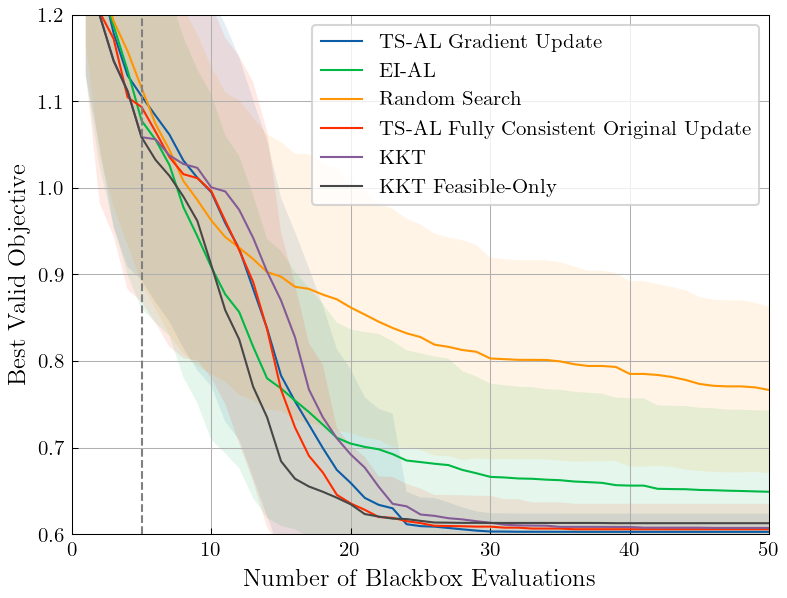

In [279]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 51)]
plt.plot(iters, ts_al_kkt_lsq_results_mean[:50], label="TS-AL Gradient Update")
# plt.plot(iters, ts_al_original_lsq_results_mean[:50], label="TS-AL Original Update")
plt.plot(iters, original_albo_lsq_results_mean, label="EI-AL")
plt.plot(iters, random_lsq_results_mean[:50], label="Random Search")
plt.plot(iters, consistent_results_mean[:50], label="TS-AL Fully Consistent Original Update")
plt.plot(iters, kkt_lsq_results_mean[:50], label="KKT")
plt.plot(iters, kkt_feasible_only_lsq_results_mean[:50], label="KKT Feasible-Only")
plt.axvline(x=5, color='grey', linestyle='--')
plt.fill_between(iters, ts_al_kkt_lsq_results_mean[:50]+ts_al_kkt_lsq_results_std[:50], ts_al_kkt_lsq_results_mean[:50]-ts_al_kkt_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, ts_al_original_lsq_results_mean[:50]+ts_al_original_lsq_results_std[:50], ts_al_original_lsq_results_mean[:50]-ts_al_original_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_lsq_results_mean[:50]+original_albo_lsq_results_std[:50], original_albo_lsq_results_mean[:50]-original_albo_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, random_lsq_results_mean[:50]+random_lsq_results_std[:50], random_lsq_results_mean[:50]-random_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, consistent_results_mean[:50]+consistent_results_std[:50], consistent_results_mean[:50]-consistent_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 50)
plt.ylim(0.6, 1.2)
plt.show()

In [280]:
original_albo_lsq_results_median[40]

0.602617523938359

In [281]:
consistent_results_median[40]

0.5998064434295188

In [282]:
np.quantile(consistent_results, 0.95, axis=0)

array([1.596875  , 1.4       , 1.4       , 1.4       , 1.4       ,
       1.4       , 1.4       , 1.4       , 1.4       , 1.4       ,
       1.4       , 1.4       , 1.4       , 1.4       , 1.17261813,
       1.00530465, 0.92578125, 0.8515625 , 0.75742272, 0.75742272,
       0.75045009, 0.75001022, 0.75000352, 0.75000307, 0.75000159,
       0.75000104, 0.75000104, 0.75000104, 0.75000073, 0.75000073,
       0.63776299, 0.63776299, 0.6059062 , 0.60400649, 0.60400649,
       0.59999615, 0.59999615, 0.59988412, 0.59986029, 0.59986029,
       0.59986029, 0.59986029, 0.59985963, 0.59984391, 0.59984009,
       0.59983461, 0.59983234, 0.59983234, 0.59983082, 0.59983082])

In [285]:
np.quantile(original_albo_lsq_results, 0.95, axis=0)

array([1.47774058, 1.48829959, 1.49768517, 1.49578803, 1.44529629,
       1.41120293, 1.40049002, 1.32038887, 1.25152173, 1.25152173,
       1.22530345, 1.21557907, 1.11676691, 1.11146964, 1.10105229,
       1.02560011, 1.02560011, 0.98496569, 0.96956692, 0.96892206,
       0.96679533, 0.96390506, 0.96074552, 0.95633289, 0.94878021,
       0.94442087, 0.94442087, 0.92230704, 0.92230704, 0.92041927,
       0.90846306, 0.89191355, 0.89191355, 0.87334854, 0.87334854,
       0.87294721, 0.87294721, 0.87294721, 0.87272546, 0.87272546,
       0.87272546, 0.86627552, 0.86627552, 0.86627552, 0.86627552,
       0.86313678, 0.86313678, 0.86313678, 0.86313678, 0.86313678])

### GSBP

In [286]:
ts_al_kkt_gsbp_results, ts_al_kkt_gsbp_results_mean, ts_al_kkt_gsbp_results_median, ts_al_kkt_gsbp_results_std = process_ts_gsbp_results("../results/05-04-23/gsbp/al_kkt_update/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_original_gsbp_results, ts_al_original_gsbp_results_mean, ts_al_original_gsbp_results_median, ts_al_original_gsbp_results_std = process_ts_gsbp_results("../results/05-04-23/gsbp/al_original_update/data/", 50, 2.1, equality_tolerance=0.01)
sobol_results, sobol_results_mean, sobol_results_median, sobol_results_std = process_ts_gsbp_results("../results/11-04-23/gsbp_ts_al_original_sobol_conservative_penalty/data/",
                                                                                                     50, 2.1, equality_tolerance=0.01)
true_sobol_results, true_sobol_results_mean, true_sobol_results_median, true_sobol_results_std = process_ts_gsbp_results("../results/13-04-23/gsbp_ts_al_original_sobol_conservative_penalty/data/", 50, 2.1, equality_tolerance=0.01)
aggressive_results, aggressive_results_mean, aggressive_results_median, aggressive_results_std = process_ts_gsbp_results("../results/12-04-23/gsbp_ts_al_original_sobol_aggressive_penalty/data/", 50, 2.1, equality_tolerance=0.01)
true_aggressive_results, true_aggressive_results_mean, true_aggressive_results_median, true_aggressive_results_std = process_ts_gsbp_results("../results/13-04-23/gsbp_ts_al_original_sobol_aggressive_penalty/data/", 50, 2.1, equality_tolerance=0.01)
original_albo_gsbp_results, original_albo_gsbp_results_mean, original_albo_gsbp_results_median, original_albo_gsbp_results_std = process_original_albo_gsbp_results("../results/original_albo/gsbp/slack_al_optim_correct_rho_update_urate_one/data/", 50, 2.1)
random_gsbp_results, random_gsbp_results_mean, random_gsbp_results_median, random_gsbp_results_std = process_ts_gsbp_results("../results/11-04-23/gsbp_random/", 50, 2.1, equality_tolerance=0.01)
final_aggressive_results, final_aggressive_results_mean, final_aggressive_results_median, final_aggressive_results_std = process_ts_gsbp_results("../results/15-04-23/gsbp_aggressive_fully_consistent/data/", 50, 2.1, equality_tolerance=0.01)
final_conservative_results, final_conservative_results_mean, final_conservative_results_median, final_conservative_results_std = process_ts_gsbp_results("../results/15-04-23/gsbp_conservative_fully_consistent/data/", 50, 2.1, equality_tolerance=0.01)
kkt_gsbp_results, kkt_gsbp_results_mean, kkt_gsbp_results_median, kkt_gsbp_results_std = process_kkt_gsbp_results("../results/09-04-23/kkt_gsbp_ts/data/", 15, 2.1, equality_tolerance=0.01)
kkt_feasible_only_gsbp_results, kkt_feasible_only_gsbp_results_mean, kkt_feasible_only_gsbp_results_median, kkt_feasible_only_gsbp_results_std = process_kkt_gsbp_results("../results/09-04-23/kkt_gsbp_feasible_only_ts/data/", 15, 2.1, equality_tolerance=0.01)

original_conservative_results, original_conservative_results_mean, original_conservative_results_median, original_conservative_results_std = process_original_albo_gsbp_results("../results/original_albo/gsbp/slack_al_optim_conservative_rho_update_urate_one/data/", 50, 2.1)

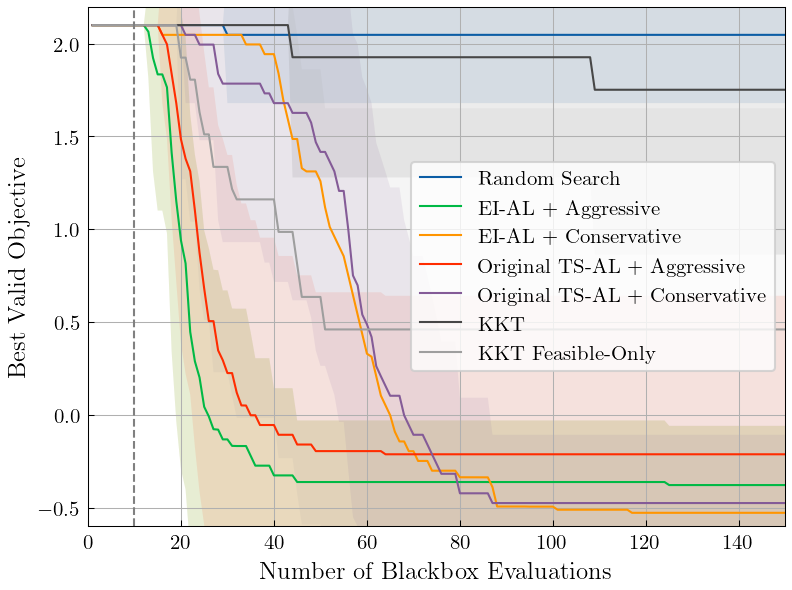

In [287]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 151)]
# plt.plot(iters, ts_al_kkt_gsbp_results_mean[:150], label="TS-AL Gradient Update")
# plt.plot(iters, ts_al_original_gsbp_results_mean[:150], label="TS-AL Original Update")
plt.plot(iters, random_gsbp_results_mean[:150], label="Random Search")
plt.plot(iters, original_albo_gsbp_results_mean, label="EI-AL + Aggressive")
plt.plot(iters, original_conservative_results_mean, label="EI-AL + Conservative")
# plt.plot(iters, aggressive_results_mean[:150], label="Sobol + Aggressive Penalty Reduction")
# plt.plot(iters, true_sobol_results_mean[:150], label="True Sobol + Conservative Penalty Reduction")
# plt.plot(iters, true_aggressive_results_mean[:150], label="True Sobol + Aggressive Penalty Reduction")
plt.plot(iters, final_aggressive_results_mean[:150], label="Original TS-AL + Aggressive")
plt.plot(iters, final_conservative_results_mean[:150], label="Original TS-AL + Conservative")
plt.plot(iters, kkt_gsbp_results_mean[:150], label="KKT")
plt.plot(iters, kkt_feasible_only_gsbp_results_mean[:150], label="KKT Feasible-Only")
plt.axvline(x=10, color='grey', linestyle='--')
plt.fill_between(iters, random_gsbp_results_mean[:150]+random_gsbp_results_std[:150], random_gsbp_results_mean[:150]-random_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_gsbp_results_mean[:150]+original_albo_gsbp_results_std[:150],
                 original_albo_gsbp_results_mean[:150]-original_albo_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_gsbp_results_mean[:150]+original_albo_gsbp_results_std[:150],
                 original_albo_gsbp_results_mean[:150]-original_albo_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, final_aggressive_results_mean[:150]+final_aggressive_results_std[:150],
                 final_aggressive_results_mean[:150]-final_aggressive_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, final_conservative_results_mean[:150]+final_conservative_results_std[:150],
                 final_conservative_results_mean[:150]-final_conservative_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, kkt_gsbp_results_mean[:150]+kkt_gsbp_results_std[:150],
                 kkt_gsbp_results_mean[:150]-kkt_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, kkt_feasible_only_gsbp_results_mean[:150]+kkt_feasible_only_gsbp_results_std[:150],
                 kkt_feasible_only_gsbp_results_mean[:150]-kkt_feasible_only_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)

plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 150)
plt.ylim(-0.6, 2.2)
plt.show()

In [288]:
def fraction_of_runs_found_feasible_point(all_runs: np.array,
                                          num_runs: int,
                                          failure_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_feasible_point = np.where(all_runs == failure_val, 0, 1)
    feasible_fraction = np.sum(found_feasible_point, axis=0)/num_runs
    return feasible_fraction

In [289]:
feasible_fraction_final_aggressive = fraction_of_runs_found_feasible_point(final_aggressive_results, 50, 2.1)
feasible_fraction_final_conservative = fraction_of_runs_found_feasible_point(final_conservative_results, 50, 2.1)
feasible_fraction_random_gsbp = fraction_of_runs_found_feasible_point(random_gsbp_results, 50, 2.1)
feasible_fraction_original_albo_gsbp = fraction_of_runs_found_feasible_point(original_albo_gsbp_results, 50, 2.1)
feasible_fraction_original_conservative = fraction_of_runs_found_feasible_point(original_conservative_results, 50, 2.1)

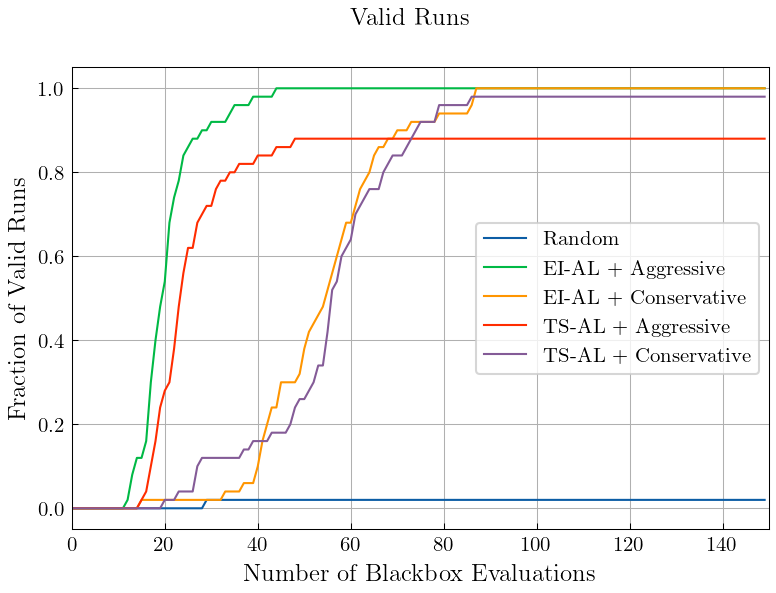

In [290]:
plt.figure(figsize=(6,4))
plt.plot(feasible_fraction_random_gsbp, label="Random")
plt.plot(feasible_fraction_original_albo_gsbp, label="EI-AL + Aggressive")
plt.plot(feasible_fraction_original_conservative, label="EI-AL + Conservative")
plt.plot(feasible_fraction_final_aggressive, label="TS-AL + Aggressive")
plt.plot(feasible_fraction_final_conservative, label="TS-AL + Conservative")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Fraction of Valid Runs')
plt.suptitle("Valid Runs")
plt.legend()
plt.xlim(0, 150)
plt.legend()

In [291]:
def fraction_of_runs_found_optimal_point(all_runs: np.array,
                                         num_runs: int,
                                         optimal_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_optimal_point = np.where(all_runs == optimal_val, 1, 0)
    optimal_fraction = np.sum(found_optimal_point, axis=0)/num_runs
    return optimal_fraction

In [292]:
optimal_fraction_final_aggressive = fraction_of_runs_found_optimal_point(final_aggressive_results, 50, -0.5273951)
optimal_fraction_final_conservative = fraction_of_runs_found_optimal_point(final_conservative_results, 50, -0.5273951)
optimal_fraction_random_gsbp = fraction_of_runs_found_optimal_point(random_gsbp_results, 50, -0.5273951)
optimal_fraction_original_albo_gsbp = fraction_of_runs_found_optimal_point(original_albo_gsbp_results, 50, -0.5273951)
optimal_fraction_original_conservative = fraction_of_runs_found_optimal_point(original_conservative_results, 50, -0.5273951)

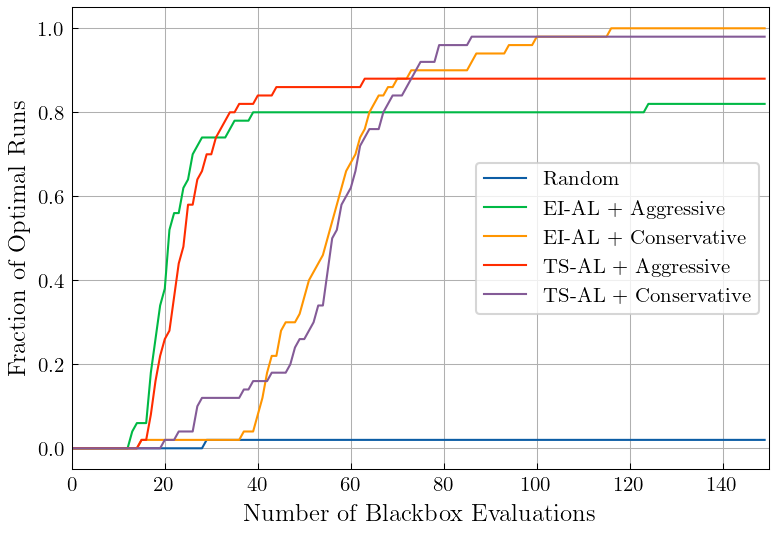

In [293]:
plt.figure(figsize=(6,4))
plt.plot(optimal_fraction_random_gsbp, label="Random")
plt.plot(optimal_fraction_original_albo_gsbp, label="EI-AL + Aggressive")
plt.plot(optimal_fraction_original_conservative, label="EI-AL + Conservative")
plt.plot(optimal_fraction_final_aggressive, label="TS-AL + Aggressive")
plt.plot(optimal_fraction_final_conservative, label="TS-AL + Conservative")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Fraction of Optimal Runs')
plt.legend()
plt.xlim(0, 150)
plt.legend()

In [243]:
# Run 3 shows a pronounced difference
run = 7
with open(f"../results/14-04-23/lsq_fully_consistent/data/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    fully_consistent_lambda = pickle.load(fp)

for i in range(len(fully_consistent_lambda[INEQUALITY_CONSTRAINT_ONE])):
    fully_consistent_lambda[INEQUALITY_CONSTRAINT_ONE][i] = fully_consistent_lambda[INEQUALITY_CONSTRAINT_ONE][i].numpy()[0]

with open(f"../results/04-04-23/lsq/al_kkt_update/data/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    gradient_based_lambda = pickle.load(fp)

for i in range(len(gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE])):
    gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE][i] = float(np.squeeze(gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE][i].numpy()))

with open(f"../results/original_albo/lsq/slack_al_optim_correct_rho_update_urate_one/data/run_{run}_results.json", "rb") as fp:
    original_lambda = json.load(fp)
    original_ineq_one_lambda = [lm[0] for lm in original_lambda['lambda']]

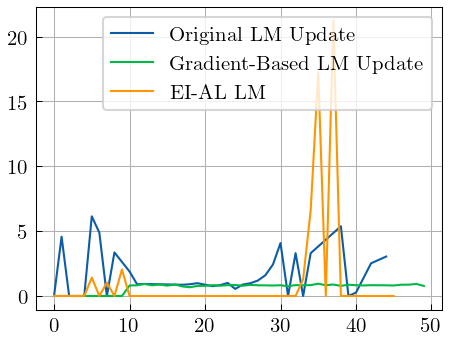

In [245]:
plt.plot(fully_consistent_lambda[INEQUALITY_CONSTRAINT_ONE], label="Original LM Update")
plt.plot(gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE], label="Gradient-Based LM Update")
plt.plot(original_ineq_one_lambda, label="EI-AL LM")
plt.legend(loc="upper right")

In [204]:
run = 4
with open(f"../results/04-04-23/lsq/al_kkt_update/data/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    gradient_based_lambda = pickle.load(fp)

for i in range(len(gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE])):
    gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE][i] = float(np.squeeze(gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE][i].numpy()))
print(gradient_based_lambda[INEQUALITY_CONSTRAINT_ONE])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7703351679797862, 0.9133116284761422, 0.9110399781895281, 0.5992712115609311, 0.0, 0.8574267897954585, 0.8821428541131426, 0.7241808806335228, 1.0226624477185762, 0.8608141196343324, 0.7932197439427884, 0.9416672995350002, 0.8803415343262884, 0.8486724989779528, 0.9011403425235858, 0.7535231665135412, 0.7841042819938608, 0.8809624083545806, 0.7518121672148221, 0.627595337427179, 0.9401098857564392, 0.9967987714073796, 0.7708117538976413, 0.8078011046100675, 0.8641623831115449, 0.8385039661025042, 0.8360664357106994, 0.7806531710231235, 0.905900811262045, 0.8813708922004733, 0.8846609881888794, 0.8877866343511505, 0.8873914864878615, 0.8908051367160585, 0.9999135296103681, 0.0, 0.8217144481289681, 0.9228178296212538, 0.8916047547848078, 0.8173902650795054, 0.8391424609552462, 0.9109371254018939]


In [24]:
with open(f"../results/09-02-23/batch_1_automatic_penalty/run_3_inequality_lambda_progression.pkl", "rb") as fp:
    lambd = pickle.load(fp)
lambd

{'INEQUALITY_CONSTRAINT_ONE': [<tf.Variable 'Variable:0' shape=(1, 1, 1) dtype=float64, numpy=array([[[0.]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.27520453]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-6.66133815e-16]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.23296362]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[6.6606006]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[21.84801114]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[52.59575154]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[37.03868473]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[193.69058899]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.96464698]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=

In [13]:
with open(f"../results/11-04-23/gsbp_ts_al_original_sobol_conservative_penalty/data/run_1_trick_location_trajectory_observations.pkl", "rb") as fp:
    trick_obs = pickle.load(fp)

In [ ]:
run=2
with open(f"../results/12-04-23/gsbp_ts_al_original_sobol_aggressive_penalty/data/run_{run}_data.pkl", "rb") as fp:
    data = pickle.load(fp)
data["OBJECTIVE"].observations[-10]

In [167]:
run = 26
with open(f"../results/05-04-23/gsbp/al_original_update/data/run_{run}_data.pkl", "rb") as fp:
    data = pickle.load(fp)
data["OBJECTIVE"].query_points[:10]

<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
array([[0.65062058, 0.23672309],
       [0.13210708, 0.59205994],
       [0.59676325, 0.00981244],
       [0.06743639, 0.41250731],
       [0.96200489, 0.13931285],
       [0.33516351, 0.16665507],
       [0.73143159, 0.80984831],
       [0.23665159, 0.40800009],
       [0.67895293, 0.70223735],
       [0.64627307, 0.37090931]])>

In [48]:
print(true_aggressive_results[:,-1])

[-0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
  2.1        -0.5273951   2.1        -0.5273951  -0.5273951  -0.5273951
  0.32428761 -0.5273951  -0.5273951   2.1        -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
  2.1        -0.5273951  -0.5273951  -0.5273951   2.1        -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951   2.1       ]


In [40]:
print(aggressive_results[:,-1])

[-0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951  2.1        2.1
 -0.5273951 -0.5273951]


In [15]:
print(true_sobol_results[:,-1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951]


In [41]:
print(sobol_results[:,-1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
  2.1       -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951]


In [165]:
print(ts_al_original_gsbp_results[:,-1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951
  2.1       -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951  2.1       -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951]


In [160]:
print(original_albo_gsbp_results[:,-100])

[-0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951   0.31824271
 -0.5273951   0.29696942 -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951   0.28881867 -0.5273951   0.29571856  0.31928504
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951   0.2906346
 -0.5273951  -0.5273951   0.29479246  0.31416716 -0.5273951   0.30049195
 -0.5273951   0.29887258]


In [307]:
from absl import app, flags
import tensorflow as tf
import numpy as np
import trieste
from trieste.acquisition.optimizer import generate_al_continuous_optimizer
from trieste.acquisition.function.new_constrained_thompson_sampling import BatchThompsonSamplingAugmentedLagrangian
from trieste.acquisition.rule import ALEfficientGlobalOptimization
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
from functions import constraints
from functions import objectives
from functools import partial
import pickle

In [308]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"

In [316]:
def create_model(search_space, num_rff_features, data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7, kernel_priors=True)
    return GaussianProcessRegression(gpr, num_rff_features=num_rff_features)

In [317]:
search_space = Box([0.0, 0.0], [1.0, 1.0])

observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.goldstein_price,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        EQUALITY_CONSTRAINT_ONE=constraints.centered_branin,
        EQUALITY_CONSTRAINT_TWO=constraints.parr_constraint)

initial_inputs = search_space.sample_sobol(10, skip=42+20)
print(f"Initial Inputs: {initial_inputs}")
initial_data = observer(initial_inputs)
initial_models = trieste.utils.map_values(partial(create_model, search_space, 1000),
                                          initial_data)

Initial Inputs: [[0.015625  0.796875 ]
 [0.0234375 0.3984375]
 [0.5234375 0.8984375]
 [0.7734375 0.1484375]
 [0.2734375 0.6484375]
 [0.3984375 0.0234375]
 [0.8984375 0.5234375]
 [0.6484375 0.2734375]
 [0.1484375 0.7734375]
 [0.2109375 0.2109375]]


In [318]:
initial_models['EQUALITY_CONSTRAINT_ONE'].model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,(),float64,-0.19755
GPR.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.146
GPR.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(2,)",float64,[0.28284 0.28284]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.0
GPR.data[0],ResourceVariable,,,False,"(None, 2)",float64,"[[0.01562, 0.79688..."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[-0.05833...


In [26]:
run = 6
with open(f"../results/05-04-23/gsbp/al_original_update/data/run_{run}_data.pkl", "rb") as fp:
    data = pickle.load(fp)
data["OBJECTIVE"].query_points

<tf.Tensor: shape=(150, 2), dtype=float64, numpy=
array([[0.9286243 , 0.77142849],
       [0.34055484, 0.86262469],
       [0.33446332, 0.36532227],
       [0.09988221, 0.05510078],
       [0.19258045, 0.08625854],
       [0.43099064, 0.42097884],
       [0.06000729, 0.60409479],
       [0.34099581, 0.56349509],
       [0.96959263, 0.27337429],
       [0.32161795, 0.04567945],
       [0.33554927, 0.35832188],
       [0.47987162, 0.35773457],
       [0.31436599, 0.39925758],
       [0.27336529, 0.42356026],
       [0.36645972, 0.43781978],
       [0.38248333, 0.46620647],
       [0.30451596, 0.45710047],
       [0.34985106, 0.45500518],
       [0.80822296, 1.        ],
       [1.        , 0.32401945],
       [0.92177362, 0.28653998],
       [0.26717084, 0.47292282],
       [0.20558167, 0.37163326],
       [0.96528689, 0.4936634 ],
       [0.93100886, 0.4512978 ],
       [0.95011553, 0.46817887],
       [0.94646756, 0.46927999],
       [0.94774845, 0.46899851],
       [0.94767733, 0.4685